In [2]:
# Uncomment and run this cell if you're on Colab or Kaggle
!git clone https://github.com/nlp-with-transformers/notebooks.git
%cd notebooks
from install import *
install_requirements()

Cloning into 'notebooks'...
remote: Enumerating objects: 526, done.
remote: Counting objects: 100% (173/173), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 526 (delta 143), reused 135 (delta 126), pack-reused 353
Receiving objects: 100% (526/526), 28.62 MiB | 11.56 MiB/s, done.
Resolving deltas: 100% (250/250), done.
Updating files: 100% (127/127), done.
/content/notebooks
⏳ Installing base requirements ...
✅ Base requirements installed!
⏳ Installing Git LFS ...
✅ Git LFS installed!


In [3]:
# hide
from utils import *
setup_chapter()

Using transformers v4.16.2
Using datasets v1.16.1


# Text Generation

<img alt="LM Meta Learning" width="800" caption="During pretraining, language models are exposed to sequences of tasks that can be adapted during inference (courtesy of Tom B. Brown)" src="https://github.com/wxmlong2012/notebooks/blob/dev/images/chapter05_lm-meta-learning.png?raw=1" id="lm-meta-learning"/>

<img alt="Meena" width="300" caption="Meena on the left telling a corny joke to a human on the right (courtesy of Daniel Adiwardana and Thang Luong)" src="https://github.com/wxmlong2012/notebooks/blob/dev/images/chapter05_meena.png?raw=1" id="meena"/>

## The Challenge with Generating Coherent Text

<img alt="Text generation" width="700" caption="Generating text from an input sequence by adding a new word to the input at each step" src="https://github.com/wxmlong2012/notebooks/blob/dev/images/chapter05_text-generation.png?raw=1" id="text-generation"/>

## Greedy Search Decoding

In [24]:
# hide_output
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

device = "cuda" if torch.cuda.is_available() else "cpu"
# gpt2-xl is the best and largest gpt2 model, the free version of colab could not
# handle the increased memory. Instead, gpt2-medium is used for demo.
model_name = "gpt2-medium"
# model_name = "gpt2-xl"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

Downloading:   0%|          | 0.00/718 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

In [25]:
import pandas as pd
input_txt = "Transformers are the"
input_ids = tokenizer(input_txt, return_tensors="pt")

In [26]:
input_ids


{'input_ids': tensor([[41762,   364,   389,   262]]), 'attention_mask': tensor([[1, 1, 1, 1]])}

In [27]:
# hide_output
import pandas as pd

input_txt = "Transformers are the"
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
iterations = []
n_steps = 8
choices_per_step = 5

with torch.no_grad():
    for _ in range(n_steps):
        iteration = dict()
        iteration["Input"] = tokenizer.decode(input_ids[0])
        output = model(input_ids=input_ids)
        # Select logits of the first batch and the last token and apply softmax
        next_token_logits = output.logits[0, -1, :]
        next_token_probs = torch.softmax(next_token_logits, dim=-1)
        sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)
        # Store tokens with highest probabilities
        for choice_idx in range(choices_per_step):
            token_id = sorted_ids[choice_idx]
            token_prob = next_token_probs[token_id].cpu().numpy()
            token_choice = (
                f"{tokenizer.decode(token_id)} ({100 * token_prob:.2f}%)"
            )
            iteration[f"Choice {choice_idx+1}"] = token_choice
        # Append predicted next token to input
        input_ids = torch.cat([input_ids, sorted_ids[None, 0, None]], dim=-1)
        iterations.append(iteration)

pd.DataFrame(iterations)

,Input,Choice 1,Choice 2,Choice 3,Choice 4,Choice 5
0,Transformers are the,most (8.37%),only (3.35%),best (2.75%),first (2.54%),ultimate (2.20%)
1,Transformers are the most,powerful (20.77%),common (7.09%),popular (5.09%),important (3.29%),advanced (2.72%)
2,Transformers are the most powerful,beings (9.43%),and (8.35%),of (4.61%),Transformers (4.34%),", (3.83%)"
3,Transformers are the most powerful beings,in (56.15%),on (18.99%),known (3.12%),of (3.09%),to (2.18%)
4,Transformers are the most powerful beings in,the (72.89%),existence (11.20%),all (3.40%),creation (1.81%),Transformers (1.18%)
5,Transformers are the most powerful beings in the,universe (67.94%),Universe (5.41%),Marvel (4.40%),Transformers (3.49%),mult (3.47%)
6,Transformers are the most powerful beings in t...,. (35.28%),", (34.16%)",and (12.94%),; (1.55%),! (1.34%)
7,Transformers are the most powerful beings in t...,They (32.09%),\n (4.97%),Their (4.93%),The (3.85%),But (2.88%)


In [30]:
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output = model.generate(input_ids, max_new_tokens=n_steps, do_sample=False)
print(tokenizer.decode(output[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The researchers, led by Dr. David


In [31]:
max_length = 128
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output_greedy = model.generate(input_ids, max_length=max_length,
                               do_sample=False)
print(tokenizer.decode(output_greedy[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The researchers, led by Dr. David M. Koehler, a professor of anthropology at the
University of Colorado, Boulder, discovered the unicorns in the remote valley of
La Paz, in the Andes Mountains.


"We were surprised to find that the unicorns spoke perfect English," said
Koehler. "They were very friendly and friendly with us. They were very friendly
with


## Beam Search Decoding

<img alt="Beam search" width="700" caption="Beam search with two beams—the most probable sequences at each timestep are highlighted in blue" src="https://github.com/wxmlong2012/notebooks/blob/dev/images/chapter05_beam-search.png?raw=1" id="beam-search"/>

In [15]:
0.5 ** 1024

5.562684646268003e-309

In [16]:
import numpy as np

sum([np.log(0.5)] * 1024)

-709.7827128933695

In [17]:
import torch.nn.functional as F

def log_probs_from_logits(logits, labels):
    logp = F.log_softmax(logits, dim=-1)
    logp_label = torch.gather(logp, 2, labels.unsqueeze(2)).squeeze(-1)
    return logp_label

In [18]:
def sequence_logprob(model, labels, input_len=0):
    with torch.no_grad():
        output = model(labels)
        log_probs = log_probs_from_logits(
            output.logits[:, :-1, :], labels[:, 1:])
        seq_log_prob = torch.sum(log_probs[:, input_len:])
    return seq_log_prob.cpu().numpy()

In [32]:
logp = sequence_logprob(model, output_greedy, input_len=len(input_ids[0]))
print(tokenizer.decode(output_greedy[0]))
print(f"\nlog-prob: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The researchers, led by Dr. David M. Koehler, a professor of anthropology at the
University of Colorado, Boulder, discovered the unicorns in the remote valley of
La Paz, in the Andes Mountains.


"We were surprised to find that the unicorns spoke perfect English," said
Koehler. "They were very friendly and friendly with us. They were very friendly
with

log-prob: -105.66


In [33]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5,
                             do_sample=False)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The discovery was made by a team of researchers from the University of
California, Santa Cruz (UCSF) and the University of Colorado, Boulder (UCL).


The unicorns were found in a remote, previously unexplored valley, in the Andes
Mountains. Even more surprising to the researchers was the fact that the
unicorns spoke perfect English.


The team of researchers, led by

log-prob: -61.69


In [34]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5,
                             do_sample=False, no_repeat_ngram_size=2)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The discovery was made by a team of researchers from the University of
California, Santa Cruz (UCSF) and the U.S. Geological Survey (USGS). The
research was published in Nature Communications.

"This is the first time that we've seen a group of these animals in North
America," said lead author of the study, UCSF professor of geology and
geophysics,

log-prob: -87.12


## Sampling Methods

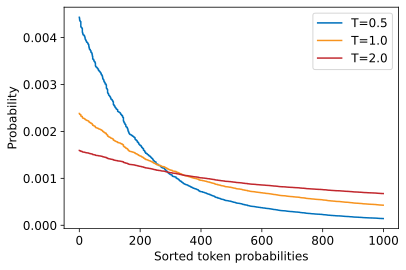

In [35]:
#hide_input

#id temperature
#alt Token probabilities as a function of temperature
#caption Distribution of randomly generated token probabilities for three selected temperatures
import matplotlib.pyplot as plt
import numpy as np

def softmax(logits, T=1):
    e_x = np.exp(logits / T)
    return e_x / e_x.sum()

logits = np.exp(np.random.random(1000))
sorted_logits = np.sort(logits)[::-1]
x = np.arange(1000)

for T in [0.5, 1.0, 2.0]:
    plt.step(x, softmax(sorted_logits, T), label=f"T={T}")
plt.legend(loc="best")
plt.xlabel("Sorted token probabilities")
plt.ylabel("Probability")
plt.show()

In [36]:
# hide
torch.manual_seed(42);

In [37]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True,
                             temperature=2.0, top_k=0)
print(tokenizer.decode(output_temp[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


Banglington noted that protagonist receiveboarding Chief Steve Whesus invaded
Speechor loclonju AgreementCONtp İmgzin A jer tur DorIN errkg meremavernmun
class YoAniamond disse *ounew Endurance whilst spear secured conferenceb ankles
coachinginventoryatelletonwarmingJanepres Wrestling chargesThings. Gu Buffer Ty
physician PET Kimvillecurrently grazSince at affopy temporou MD RIP CanadaDE


In [38]:
# hide
torch.manual_seed(42);

In [39]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True,
                             temperature=0.5, top_k=0)
print(tokenizer.decode(output_temp[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The scientists studied the DNA of the animals and discovered that they shared a
common ancestor with humans, with no genetic differences between the two
species.


The scientists also found that the unicorns had a unique way of communicating
with each other.

The researchers believe that the unicorns were born with an extra pair of eyes,
which they used to communicate with each other, and to recognise each other's


## Top-k and Nucleus Sampling

In [40]:
# hide
torch.manual_seed(42);

In [41]:
# hide
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)

In [42]:
# hide
import torch.nn.functional as F

with torch.no_grad():
    output = model(input_ids=input_ids)
    next_token_logits = output.logits[:, -1, :]
    probs = F.softmax(next_token_logits, dim=-1).detach().cpu().numpy()

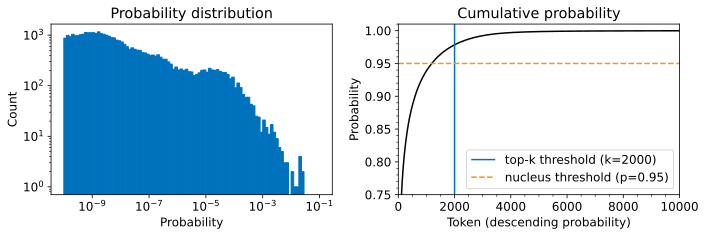

In [43]:
# hide_input

#id distribution
#alt Probability distribution of next token prediction.
#caption Probability distribution of next token prediction (left) and cumulative distribution of descending token probabilities

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))

axes[0].hist(probs[0], bins=np.logspace(-10, -1, 100), color="C0", edgecolor="C0")
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_title("Probability distribution")
axes[0].set_xlabel("Probability")
axes[0].set_ylabel("Count")
#axes[0].grid(which="major")

axes[1].plot(np.cumsum(np.sort(probs[0])[::-1]), color="black")
axes[1].set_xlim([0, 10000])
axes[1].set_ylim([0.75, 1.01])
axes[1].set_title("Cumulative probability")
axes[1].set_ylabel("Probability")
axes[1].set_xlabel("Token (descending probability)")
#axes[1].grid(which="major")
axes[1].minorticks_on()
#axes[1].grid(which='minor', linewidth='0.5')
top_k_label = 'top-k threshold (k=2000)'
top_p_label = 'nucleus threshold (p=0.95)'
axes[1].vlines(x=2000, ymin=0, ymax=2, color='C0', label=top_k_label)
axes[1].hlines(y=0.95, xmin=0, xmax=10000, color='C1', label=top_p_label, linestyle='--')
axes[1].legend(loc='lower right')
plt.tight_layout()

In [44]:
# hide
torch.manual_seed(42);

In [45]:
output_topk = model.generate(input_ids, max_length=max_length, do_sample=True,
                             top_k=50)
print(tokenizer.decode(output_topk[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The scientists studied the DNA of the animals and came across a population of
unicorns living in a mountain valley 200 km west of Chaco, Argentina.


In the years since the research led by Dr. Gabriel Gonzalez-Rozas and Dr. Jose
Luis Diaz was published, the findings have been received wide condemnation from
the media, the UN and members of the public. Although there are many problems


In [46]:
# hide
torch.manual_seed(42);

In [47]:
output_topp = model.generate(input_ids, max_length=max_length, do_sample=True,
                             top_p=0.90)
print(tokenizer.decode(output_topp[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The scientists studied the DNA of the animals and came across a population of
unicorns living in a mountain valley. The group of unicorns, called Xanthomorpha
(Xo), had a common ancestor, a species of bison called Xanthosoma, that existed
at about 10,000 years ago. In a recent study, the scientists found a population
of Xanthomorpha living


## Which Decoding Method Is Best?

## Conclusion